In [2]:
#All these packages need to be installed from pip
import gensim	#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import spacy
import copy
import nltk

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import os #For looking through files
import os.path #For managing file paths
import pickle
import dill

nlp = spacy.load('en_core_web_lg')

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
with open('donald_full.pkl', 'rb') as fin:
    donald_full = dill.load(fin)
    
with open('rawEmbeddings_skipgram.pkl', 'rb') as fin:
    rawEmbeddings = dill.load(fin)
    
with open('comparedEmbeddings_skipgram.pkl', 'rb') as fin:
    comparedEmbeddings = dill.load(fin)

In [4]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sg_param, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum(), size = 250, sg = sg_param)
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

def findDivergence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDivergence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [6]:
donald_full_w2vsub = donald_full[donald_full['created_tranche'].isin(range(5,29))]
donald_full_w2vsub['created_tranche'].value_counts(sort = False)

0         0
1         0
2         0
3         0
4         0
5     89043
6     96300
7     94613
8     91794
9     94801
10    95464
11    97989
12    97969
13    97879
14    97976
15    97996
16    96996
17    97934
18    97995
19    98007
20    98997
21    98004
22    98014
23    97788
24    97864
25    98007
26    97999
27    97977
28    98011
29        0
Name: created_tranche, dtype: int64

In [9]:
rawEmbeddings, comparedEmbeddings = compareModels(donald_full_w2vsub, 'created_tranche', sg_param=1)

with open('rawEmbeddings_skipgram.pkl', 'wb') as fout:
    dill.dump(rawEmbeddings, fout)
    
with open('comparedEmbeddings_skipgram.pkl', 'wb') as fout:
    dill.dump(comparedEmbeddings, fout)

In [ ]:
rawEmbeddings_cbow, comparedEmbeddings_cbow = compareModels(donald_full_w2vsub, 'created_tranche', sg_param=0)

with open('rawEmbeddings_cbow.pkl', 'wb') as fout:
    dill.dump(rawEmbeddings_cbow, fout)
    
with open('comparedEmbeddings_cbow.pkl', 'wb') as fout:
    dill.dump(comparedEmbeddings_cbow, fout)

In [72]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 5818 words to compare


In [74]:
wordDivergences[:25]

[('=', 19.801815666258335),
 ('r', 19.107877403497696),
 ('new', 19.089457169175148),
 ('state', 18.886118918657303),
 ('white', 18.8478369936347),
 ('high', 18.48075322806835),
 ('wall', 18.480599224567413),
 ('live', 18.465384893119335),
 ('free', 18.431381940841675),
 ('open', 18.42058916389942),
 ('law', 18.36677759885788),
 ('news', 18.36085757613182),
 ('american', 18.16840384155512),
 ('woman', 18.158180758357048),
 ('meme', 18.135443180799484),
 ('bot', 18.12203700840473),
 ('anti', 18.080137334764004),
 ('get', 18.078612133860588),
 ('make', 18.043862752616405),
 ('god', 18.016357637941837),
 ('subreddit', 17.98532209545374),
 ('war', 17.981140673160553),
 ('/r', 17.950402155518532),
 ('big', 17.81080448627472),
 ('welcome', 17.799647256731987)]

In [100]:
def divPlotter(in_word):
    pltDF = getDivergenceDF(in_word, comparedEmbeddings)
    pltDF_mean = round(pltDF.mean().mean(), 2)
    pltDF_max = round(pltDF.max().max(), 2)
    pltDF_min = round(pltDF.min().min(), 2)
    fig, ax = plt.subplots(figsize = (10, 7))
    seaborn.heatmap(pltDF, ax = ax, annot = False, 
                    vmin=0, vmax=1) #set annot True for a lot more information
    ax.set_xlabel("Starting 6-week-tranche")
    ax.set_ylabel("Final 6-week-tranche")
    ax.set_title("Linguistic change for: '{}'\nMin: {}, Mean: {}, Max:{}".format(in_word,pltDF_min, pltDF_mean, pltDF_max))
    plt.show()    

military


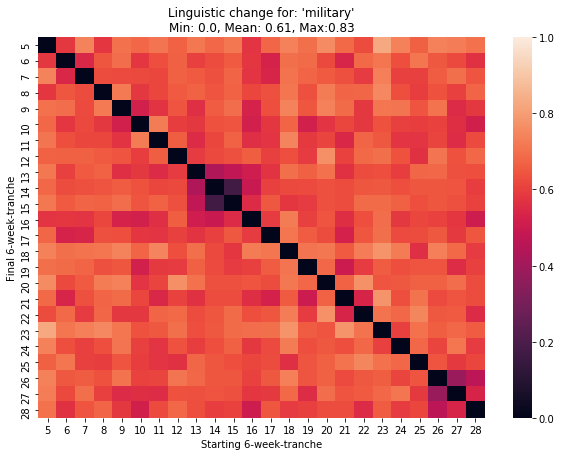

In [101]:
divPlotter('military') #elite, america, news

email


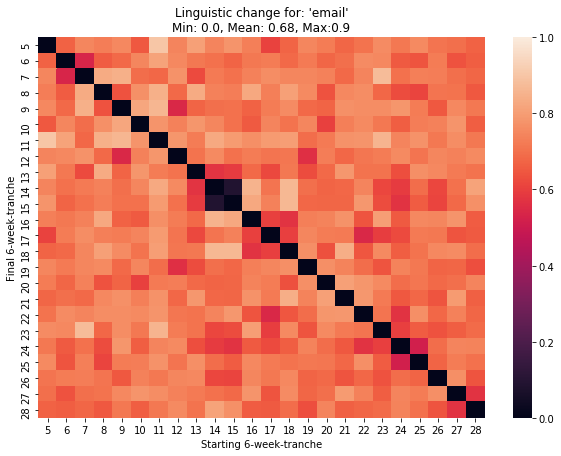

In [102]:
divPlotter('email') #elite, america, news

investigation


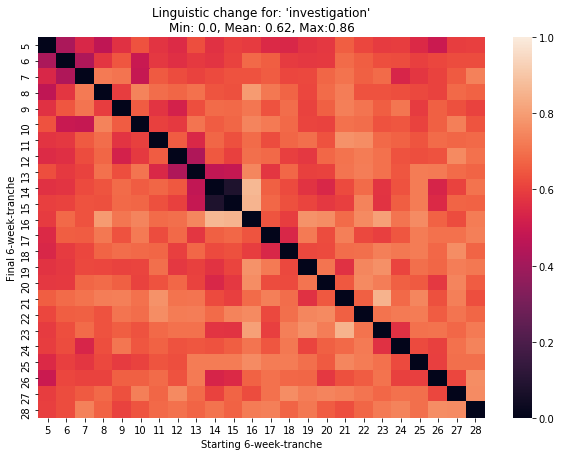

In [103]:
divPlotter('investigation') #elite, america, news

white


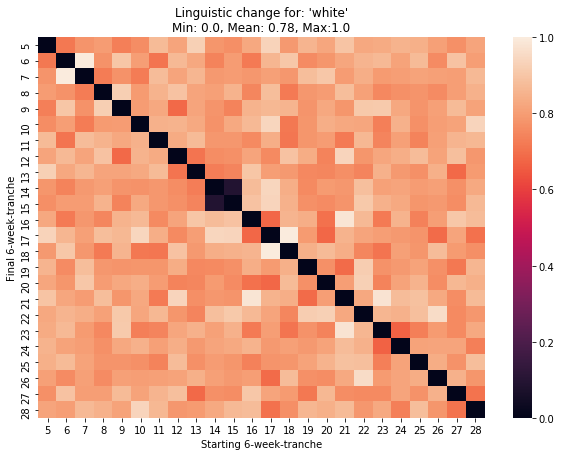

In [104]:
divPlotter('white') #elite, america, news

race


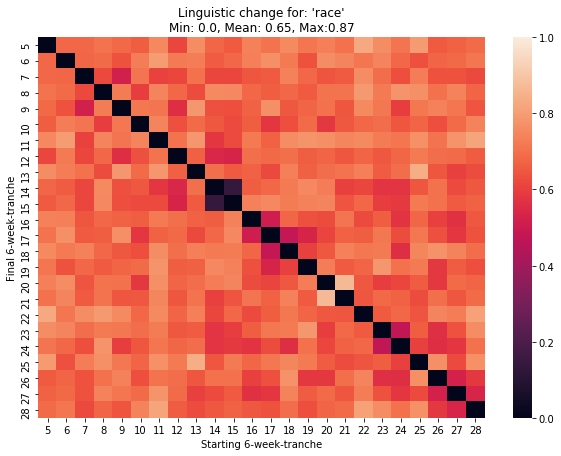

In [105]:
divPlotter('race') #elite, america, news

hack


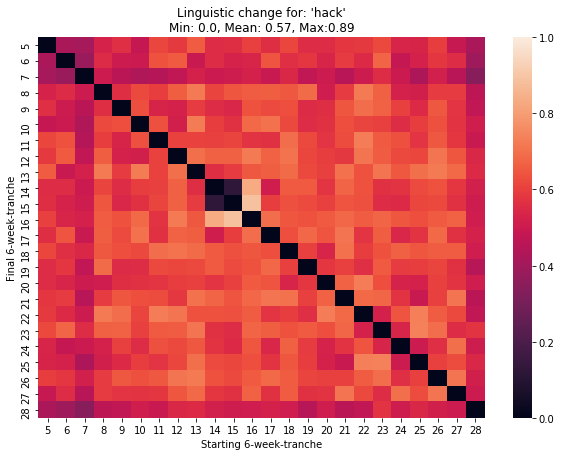

In [106]:
divPlotter('hack') #elite, america, news

russia


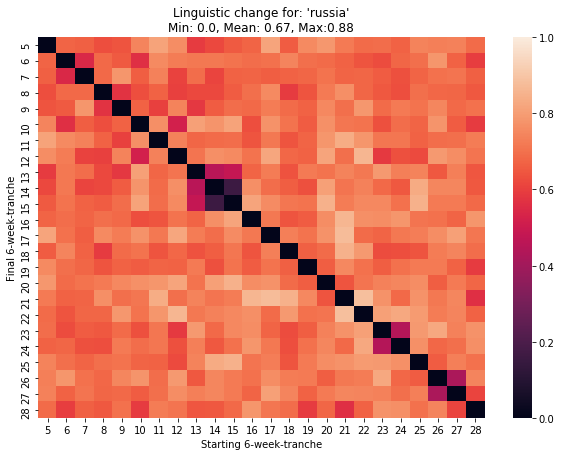

In [107]:
divPlotter('russia') #elite, america, news

republican


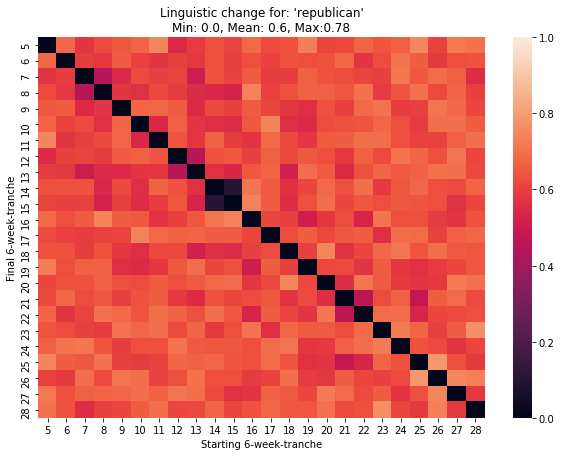

In [108]:
divPlotter('republican') #elite, america, news

democrat


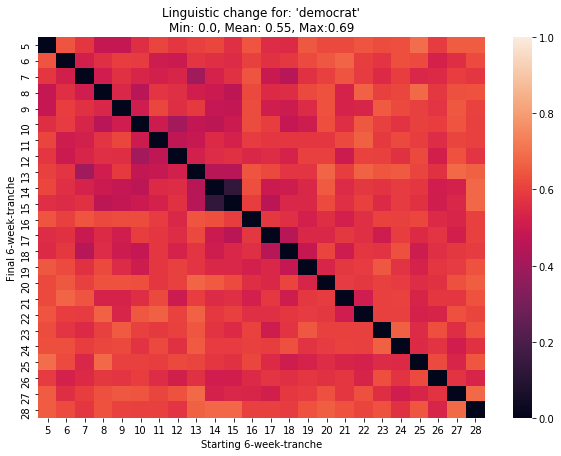

In [109]:
divPlotter('democrat') #elite, america, news

**Clinton vs Bernie**: 

clinton


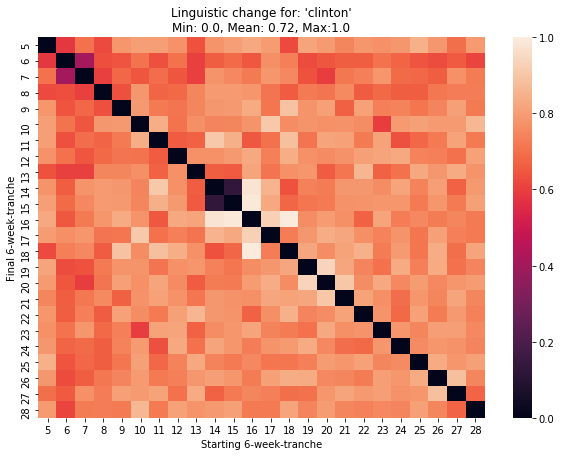

In [110]:
divPlotter('clinton') #elite, america, news

bernie


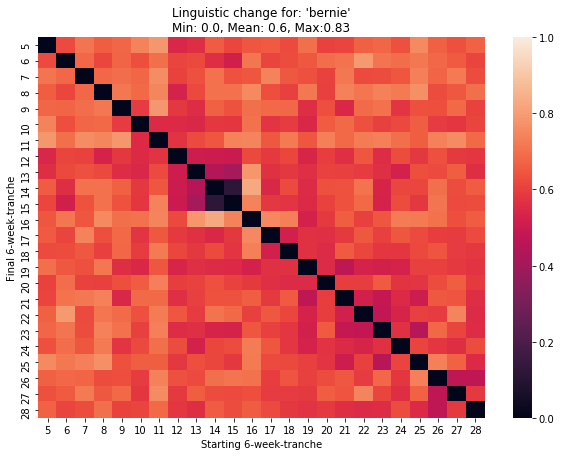

In [111]:
divPlotter('bernie') #elite, america, news

mexican


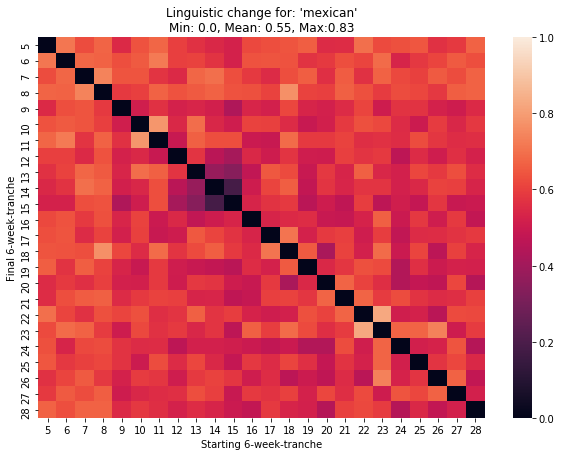

In [112]:
divPlotter('mexican') #elite, america, news

immigration


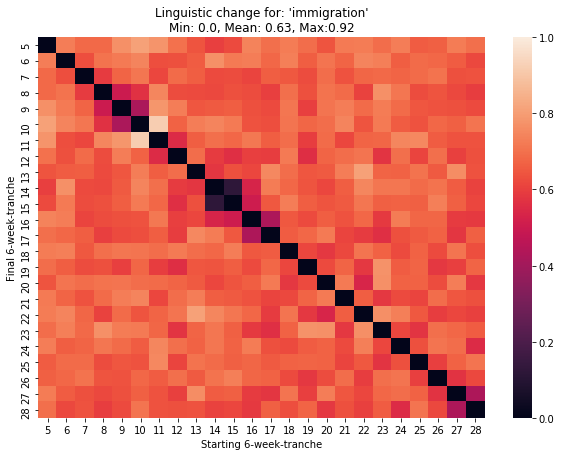

In [113]:
divPlotter('immigration') #elite, america, news

sjw


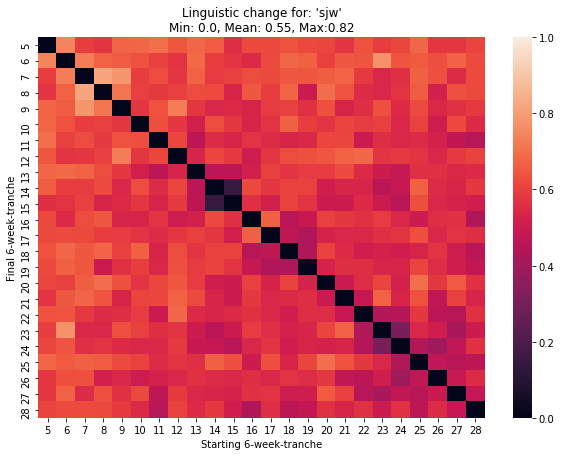

In [114]:
divPlotter('sjw') #elite, america, news

iran


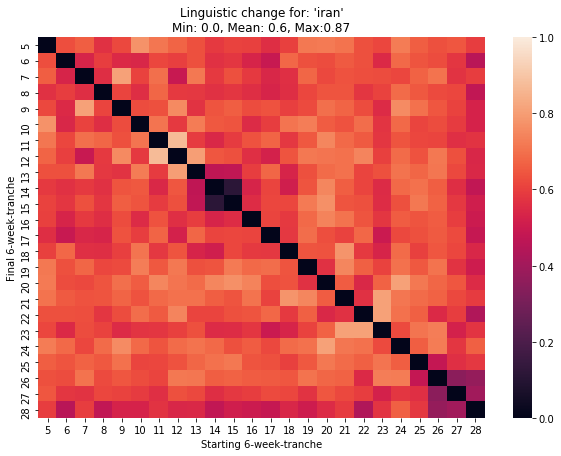

In [115]:
divPlotter('iran') #elite, america, news

economy


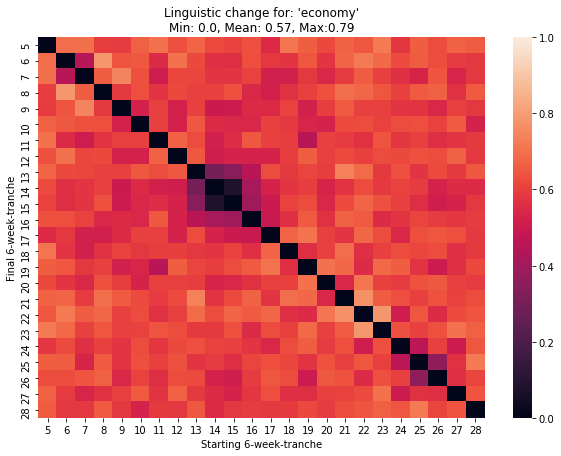

In [116]:
divPlotter('economy') #elite, america, news

facebook


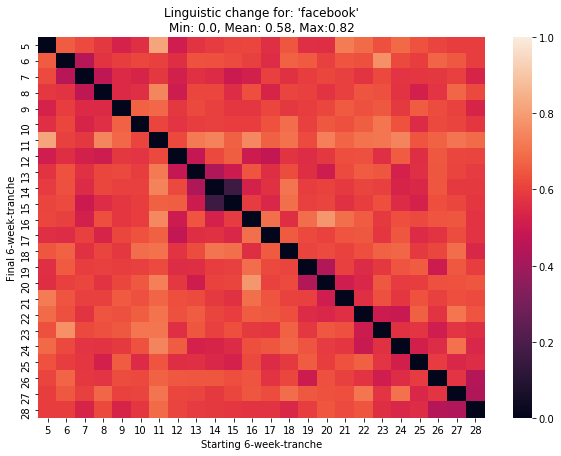

In [118]:
divPlotter('facebook') #elite, america, news

In [122]:
(1502530200 - min(donald_full['created_utc']))/(6*7*24*60*60)

18.42845816798942

In [37]:
print(min(donald_full['created_utc']) + 20*(6*7*24*60*60),
      min(donald_full['created_utc']) + 21*(6*7*24*60*60))

1508233011 1511861811


In [166]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, dim_dict, word_list):
    g = []
    i = []
    r_bw = []
    r_hw = []
    r_aw = []
    c = []
    
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Gender'].reshape(1,-1))[0][0])
        i.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Ideology'].reshape(1,-1))[0][0])
        r_bw.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Race_bw'].reshape(1,-1))[0][0])
        r_hw.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Race_hw'].reshape(1,-1))[0][0])
        r_aw.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Race_aw'].reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), dim_dict['Class'].reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 
                           'ideology': i, 
                           'race_bw': r_bw, 
                           'race_hw': r_hw, 
                           'race_aw': r_aw, 
                           'class': c}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [168]:
religions = ['christian', 'christianity', 'islam', 'muslim','jewish', 'jew', 'atheist']
countries = ['europe', 'america', 'mexico', 'libya', 'israel', 'sweden', 'syria', 'iran', 'iraq','afghanistan', 'england']
issues = ['immigration', 'job', 'economy', 'security', 'terrorism', 'trade']

In [123]:
donald_w2v_ST = rawEmbeddings[5]
donald_w2v_EL = rawEmbeddings[11]
donald_w2v_CH = rawEmbeddings[18]

In [169]:
religions_df_ST = makeDF(donald_w2v_ST, ST_dimdict, religions) 
countries_df_ST = makeDF(donald_w2v_ST, ST_dimdict, countries)
issues_df_ST = makeDF(donald_w2v_ST, ST_dimdict, issues)

religions_df_EL = makeDF(donald_w2v_EL, EL_dimdict, religions) 
countries_df_EL = makeDF(donald_w2v_EL, EL_dimdict,  countries)
issues_df_EL = makeDF(donald_w2v_EL, EL_dimdict,  issues)

religions_df_CH = makeDF(donald_w2v_CH, CH_dimdict,  religions) 
countries_df_CH = makeDF(donald_w2v_CH,  CH_dimdict, countries)
issues_df_CH = makeDF(donald_w2v_CH, CH_dimdict,  issues)

In [155]:
Gender_ST = dimension(donald_w2v_ST, ['man'], ['woman'])
Ideology_ST = dimension(donald_w2v_ST, ['conservative', 'republican', 'right'], ['democrat', 'leftist', 'liberal'])
Race_bw_ST = dimension(donald_w2v_ST, ['black','african'], ['white'])
Race_hw_ST = dimension(donald_w2v_ST, ['brown','latino','hispanic', 'mexican'], ['white'])
Race_aw_ST = dimension(donald_w2v_ST, ['asian','chinese'], ['white'])
Class_ST = dimension(donald_w2v_ST, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap'])

ST_dimdict = {}
ST_dimdict['Gender'] = Gender_ST
ST_dimdict['Ideology'] = Ideology_ST
ST_dimdict['Race_bw'] = Race_bw_ST
ST_dimdict['Race_hw'] = Race_hw_ST
ST_dimdict['Race_aw'] = Race_aw_ST
ST_dimdict['Class'] = Class_ST

In [157]:
Gender_EL = dimension(donald_w2v_EL, ['man'], ['woman'])
Ideology_EL = dimension(donald_w2v_EL, ['conservative', 'republican', 'right'], ['democrat', 'leftist', 'liberal'])
Race_bw_EL = dimension(donald_w2v_EL, ['black','african'], ['white'])
Race_hw_EL = dimension(donald_w2v_EL, ['brown','latino','hispanic', 'mexican'], ['white'])
Race_aw_EL = dimension(donald_w2v_EL, ['asian','chinese'], ['white'])
Class_EL = dimension(donald_w2v_EL, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap'])

EL_dimdict = {}
EL_dimdict['Gender'] = Gender_EL
EL_dimdict['Ideology'] = Ideology_EL
EL_dimdict['Race_bw'] = Race_bw_EL
EL_dimdict['Race_hw'] = Race_hw_EL
EL_dimdict['Race_aw'] = Race_aw_EL
EL_dimdict['Class'] = Class_EL

In [158]:
Gender_CH = dimension(donald_w2v_CH, ['man'], ['woman'])
Ideology_CH = dimension(donald_w2v_CH, ['conservative', 'republican', 'right'], ['democrat', 'leftist', 'liberal'])
Race_bw_CH = dimension(donald_w2v_CH, ['black','african'], ['white'])
Race_hw_CH = dimension(donald_w2v_CH, ['brown','latino','hispanic', 'mexican'], ['white'])
Race_aw_CH = dimension(donald_w2v_CH, ['asian','chinese'], ['white'])
Class_CH = dimension(donald_w2v_CH, ['rich', 'expensive', 'wealthy'], ['poor', 'cheap'])

CH_dimdict = {}
CH_dimdict['Gender'] = Gender_CH
CH_dimdict['Ideology'] = Ideology_CH
CH_dimdict['Race_bw'] = Race_bw_CH
CH_dimdict['Race_hw'] = Race_hw_CH
CH_dimdict['Race_aw'] = Race_aw_CH
CH_dimdict['Class'] = Class_CH

In [1]:
fig, big_axes = plt.subplots( figsize=(36, 12) , nrows=3, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Subplot row %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), 
                       top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False


# for i in range(1,10):
#     ax = fig.add_subplot(3,3,i)
#     ax.set_title('Plot title ' + str(i))

# fig.set_facecolor('w')
# plt.tight_layout()
# plt.show()


# fig = plt.figure(figsize = (36,12))
## Super-Tuesday
ax11 = fig.add_subplot(3,6,1)
PlotDimension(ax11, religions_df_ST, 'gender')
ax12 = fig.add_subplot(3,6,2)
PlotDimension(ax12, religions_df_ST, 'race_bw')
ax13 = fig.add_subplot(3,6,3)
PlotDimension(ax13, religions_df_ST, 'race_hw')
ax14 = fig.add_subplot(3,6,4)
PlotDimension(ax14, religions_df_ST, 'race_aw')
ax15 = fig.add_subplot(3,6,5)
PlotDimension(ax15, religions_df_ST, 'class')
ax16 = fig.add_subplot(3,6,6)
PlotDimension(ax16, religions_df_ST, 'ideology')
## Election Season
ax21 = fig.add_subplot(3,6,7)
PlotDimension(ax21, religions_df_EL, 'gender')
ax22 = fig.add_subplot(3,6,8)
PlotDimension(ax22, religions_df_EL, 'race_bw')
ax23 = fig.add_subplot(3,6,9)
PlotDimension(ax23, religions_df_EL, 'race_hw')
ax24 = fig.add_subplot(3,6,10)
PlotDimension(ax24, religions_df_EL, 'race_aw')
ax25 = fig.add_subplot(3,6,11)
PlotDimension(ax25, religions_df_EL, 'class')
ax26 = fig.add_subplot(3,6,12)
PlotDimension(ax26, religions_df_EL, 'ideology')
## Charlottesville
ax31 = fig.add_subplot(3,6,13)
PlotDimension(ax31, religions_df_CH, 'gender')
ax32 = fig.add_subplot(3,6,14)
PlotDimension(ax32, religions_df_CH, 'race_bw')
ax33 = fig.add_subplot(3,6,15)
PlotDimension(ax33, religions_df_CH, 'race_hw')
ax34 = fig.add_subplot(3,6,16)
PlotDimension(ax34, religions_df_CH, 'race_aw')
ax35 = fig.add_subplot(3,6,17)
PlotDimension(ax35, religions_df_CH, 'class')
ax36 = fig.add_subplot(3,6,18)
PlotDimension(ax36, religions_df_CH, 'ideology')
plt.show()

NameError: name 'plt' is not defined

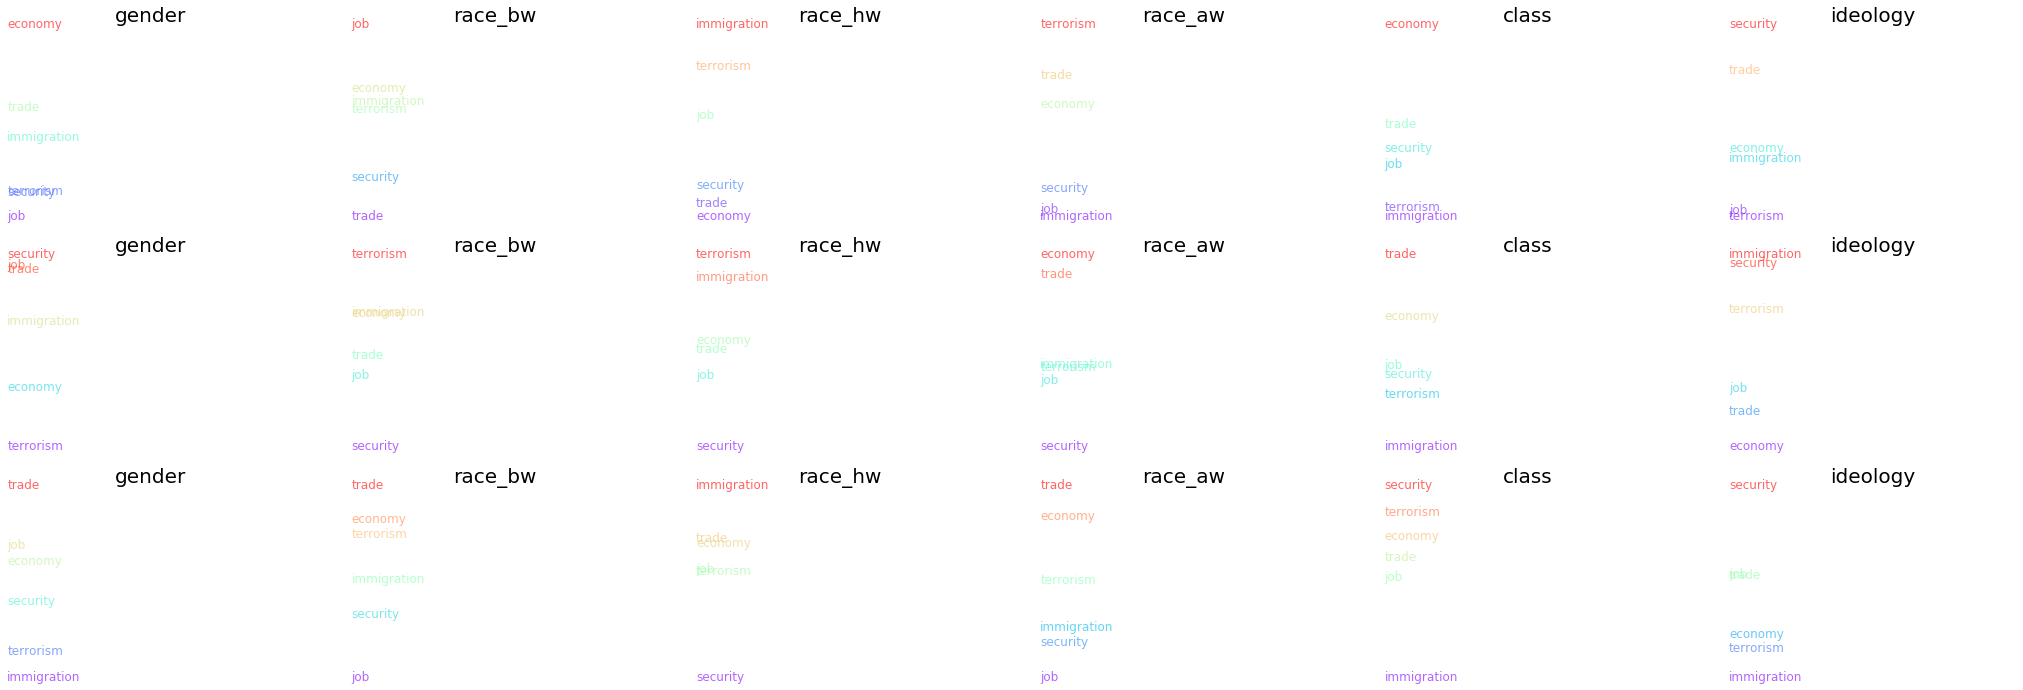

In [189]:
fig = plt.figure(figsize = (36,12))
## Super-Tuesday
ax11 = fig.add_subplot(3,6,1)
PlotDimension(ax11, issues_df_ST, 'gender')
ax12 = fig.add_subplot(3,6,2)
PlotDimension(ax12, issues_df_ST, 'race_bw')
ax13 = fig.add_subplot(3,6,3)
PlotDimension(ax13, issues_df_ST, 'race_hw')
ax14 = fig.add_subplot(3,6,4)
PlotDimension(ax14, issues_df_ST, 'race_aw')
ax15 = fig.add_subplot(3,6,5)
PlotDimension(ax15, issues_df_ST, 'class')
ax16 = fig.add_subplot(3,6,6)
PlotDimension(ax16, issues_df_ST, 'ideology')
## Election Season
ax21 = fig.add_subplot(3,6,7)
PlotDimension(ax21, issues_df_EL, 'gender')
ax22 = fig.add_subplot(3,6,8)
PlotDimension(ax22, issues_df_EL, 'race_bw')
ax23 = fig.add_subplot(3,6,9)
PlotDimension(ax23, issues_df_EL, 'race_hw')
ax24 = fig.add_subplot(3,6,10)
PlotDimension(ax24, issues_df_EL, 'race_aw')
ax25 = fig.add_subplot(3,6,11)
PlotDimension(ax25, issues_df_EL, 'class')
ax26 = fig.add_subplot(3,6,12)
PlotDimension(ax26, issues_df_EL, 'ideology')
## Charlottesville
ax31 = fig.add_subplot(3,6,13)
PlotDimension(ax31, issues_df_CH, 'gender')
ax32 = fig.add_subplot(3,6,14)
PlotDimension(ax32, issues_df_CH, 'race_bw')
ax33 = fig.add_subplot(3,6,15)
PlotDimension(ax33, issues_df_CH, 'race_hw')
ax34 = fig.add_subplot(3,6,16)
PlotDimension(ax34, issues_df_CH, 'race_aw')
ax35 = fig.add_subplot(3,6,17)
PlotDimension(ax35, issues_df_CH, 'class')
ax36 = fig.add_subplot(3,6,18)
PlotDimension(ax36, issues_df_CH, 'ideology')
plt.show()

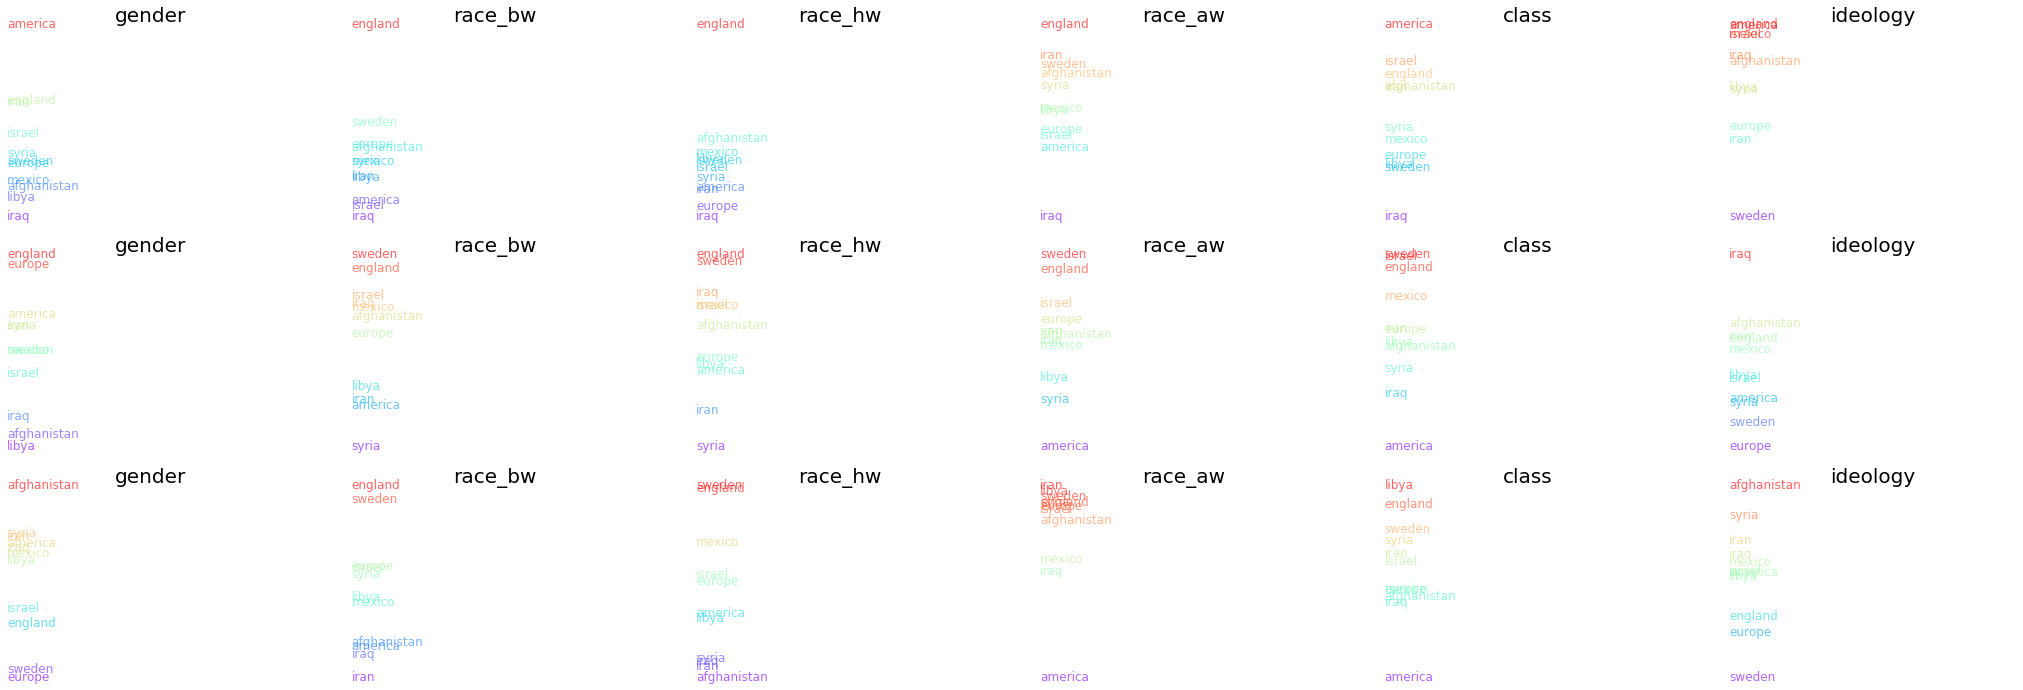

In [190]:
fig = plt.figure(figsize = (36,12))
## Super-Tuesday
ax11 = fig.add_subplot(3,6,1)
PlotDimension(ax11, countries_df_ST, 'gender')
ax12 = fig.add_subplot(3,6,2)
PlotDimension(ax12, countries_df_ST, 'race_bw')
ax13 = fig.add_subplot(3,6,3)
PlotDimension(ax13, countries_df_ST, 'race_hw')
ax14 = fig.add_subplot(3,6,4)
PlotDimension(ax14, countries_df_ST, 'race_aw')
ax15 = fig.add_subplot(3,6,5)
PlotDimension(ax15, countries_df_ST, 'class')
ax16 = fig.add_subplot(3,6,6)
PlotDimension(ax16, countries_df_ST, 'ideology')
## Election Season
ax21 = fig.add_subplot(3,6,7)
PlotDimension(ax21, countries_df_EL, 'gender')
ax22 = fig.add_subplot(3,6,8)
PlotDimension(ax22, countries_df_EL, 'race_bw')
ax23 = fig.add_subplot(3,6,9)
PlotDimension(ax23, countries_df_EL, 'race_hw')
ax24 = fig.add_subplot(3,6,10)
PlotDimension(ax24, countries_df_EL, 'race_aw')
ax25 = fig.add_subplot(3,6,11)
PlotDimension(ax25, countries_df_EL, 'class')
ax26 = fig.add_subplot(3,6,12)
PlotDimension(ax26, countries_df_EL, 'ideology')
## Charlottesville
ax31 = fig.add_subplot(3,6,13)
PlotDimension(ax31, countries_df_CH, 'gender')
ax32 = fig.add_subplot(3,6,14)
PlotDimension(ax32, countries_df_CH, 'race_bw')
ax33 = fig.add_subplot(3,6,15)
PlotDimension(ax33, countries_df_CH, 'race_hw')
ax34 = fig.add_subplot(3,6,16)
PlotDimension(ax34, countries_df_CH, 'race_aw')
ax35 = fig.add_subplot(3,6,17)
PlotDimension(ax35, countries_df_CH, 'class')
ax36 = fig.add_subplot(3,6,18)
PlotDimension(ax36, countries_df_CH, 'ideology')
plt.show()